<a href="https://colab.research.google.com/github/Kaia-nyoung/2025-ML-class/blob/main/4%EC%A3%BC%EC%B0%A8/Wine_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os, random

In [6]:
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

In [7]:
col_names = [
    "label", "Alcohol", "Malic_acid", "Ash", "Alcalinity_of_ash",
    "Magnesium", "Total_phenols", "Flavanoids", "Nonflavanoid_phenols",
    "Proanthocyanins", "Color_intensity", "Hue",
    "OD280/OD315_of_diluted_wines", "Proline"
]
df = pd.read_csv("/content/drive/MyDrive/ML-MK/wine.data", header=None, names=col_names)

In [8]:
# 3) X, y split
X = df.drop(columns=["label"])
y = df["label"]  # values are 1/2/3

In [9]:
# One-hot (3 classes). get_dummies keeps class labels as column names {1,2,3}
Y = pd.get_dummies(y)            # shape: (N, 3)
class_names = Y.columns.tolist() # [1,2,3]


In [10]:
# 4) Train/test split (stratify keeps class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, Y.values, test_size=0.2, random_state=SEED, stratify=y
)

In [11]:
# 5) Scale features (fit on TRAIN ONLY to avoid leakage)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

In [12]:
# 6) Model
model = models.Sequential([
    layers.Dense(64, activation="relu", input_shape=(X_train.shape[1],)),
    layers.Dropout(0.3),
    layers.Dense(32, activation="relu"),
    layers.Dense(y_train.shape[1], activation="softmax")  # 3 classes
])

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",   # one-hot targets
    metrics=["accuracy"]
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
# (Optional) EarlyStopping for stability on small data
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True
)

In [14]:
# 7) Train
history = model.fit(
    X_train, y_train,
    validation_split=0.2,   # 20% of TRAIN used for validation
    epochs=200,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.3439 - loss: 1.1645 - val_accuracy: 0.5172 - val_loss: 0.9706
Epoch 2/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5917 - loss: 0.9169 - val_accuracy: 0.8621 - val_loss: 0.7894
Epoch 3/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7000 - loss: 0.8020 - val_accuracy: 0.9655 - val_loss: 0.6413
Epoch 4/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8817 - loss: 0.6547 - val_accuracy: 1.0000 - val_loss: 0.5191
Epoch 5/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9200 - loss: 0.5520 - val_accuracy: 1.0000 - val_loss: 0.4135
Epoch 6/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9302 - loss: 0.4750 - val_accuracy: 1.0000 - val_loss: 0.3246
Epoch 7/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9652 - loss: 0.3894 - val_accuracy: 1.0000 - val_loss: 0.2557
Epoch 8/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9475 - loss: 0.3325 - val_accuracy: 1.0000 - val_loss:

In [15]:
# 8) Evaluate
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\n[TEST] loss={test_loss:.4f}, acc={test_acc:.4f}")


[TEST] loss=0.0808, acc=0.9444


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 232ms/step

Classification Report:
              precision    recall  f1-score   support

     class 1       0.92      1.00      0.96        12
     class 2       0.93      0.93      0.93        14
     class 3       1.00      0.90      0.95        10

    accuracy                           0.94        36
   macro avg       0.95      0.94      0.95        36
weighted avg       0.95      0.94      0.94        36



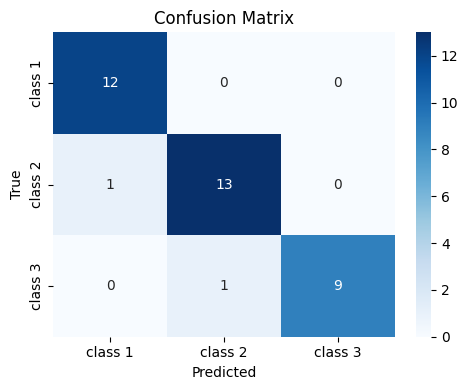

In [16]:
# 9) Predict & metrics
y_pred = model.predict(X_test)
y_test_class = np.argmax(y_test, axis=1)
y_pred_class = np.argmax(y_pred, axis=1)

print("\nClassification Report:")
print(classification_report(y_test_class, y_pred_class, target_names=[f"class {c}" for c in class_names]))

cm = confusion_matrix(y_test_class, y_pred_class)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[f"class {c}" for c in class_names],
            yticklabels=[f"class {c}" for c in class_names])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

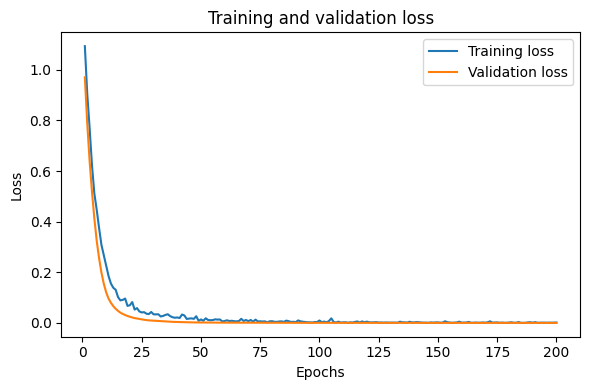

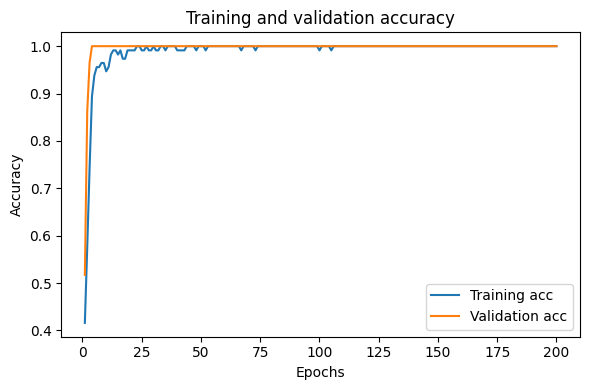

In [17]:
# 10) Learning curves
loss = history.history["loss"]
val_loss = history.history["val_loss"]
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(6,4))
plt.plot(epochs, loss, label="Training loss")
plt.plot(epochs, val_loss, label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs"); plt.ylabel("Loss"); plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4))
plt.plot(epochs, acc, label="Training acc")
plt.plot(epochs, val_acc, label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs"); plt.ylabel("Accuracy"); plt.legend(); plt.tight_layout(); plt.show()